## Crop objects from CLEVRER Vidoes automatically

In [4]:
from PIL import Image
import json
from pycocotools import mask
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import random

In [3]:
def mean_center_of_mask(mask):
    # Get the coordinates of all non-zero pixels (foreground pixels)
    foreground_pixels = np.column_stack(np.where(mask == 1))

    if foreground_pixels.shape[0] == 0:
        return None  # Return None if there are no foreground pixels

    # Calculate the mean center (centroid) by averaging the coordinates
    mean_y = int(
        np.round(np.mean(foreground_pixels[:, 0]))
    )  # Mean of y-coordinates (rows)
    mean_x = int(
        np.round(np.mean(foreground_pixels[:, 1]))
    )  # Mean of x-coordinates (columns)

    return mean_x, mean_y  # Return the (x, y) coordinates of the centroid


def crop_images_around_object(
    image_filenames: list[str],
    object_attributes: dict,
    derender: dict,
    target_folder: str,
    cropped_img_size=128,
):
    derender_frames = derender["frames"]
    padding_size = int(np.ceil(cropped_img_size / 2))

    for i, frame_dict in enumerate(derender_frames):
        objects_in_frame = frame_dict["objects"]
        video_frame = np.array(Image.open(image_filenames[i]))
        for ob in objects_in_frame:
            ob_attributes = {key: ob[key] for key in object_attributes.keys()}
            if ob_attributes == object_attributes:
                binary_mask = mask.decode(ob["mask"])
                mask_center = mean_center_of_mask(binary_mask)

                padded_video_frame = np.pad(
                    video_frame,
                    (
                        (padding_size, padding_size),
                        (padding_size, padding_size),
                        (0, 0),
                    ),
                    mode="reflect",
                )
                cropped_img = padded_video_frame[
                    mask_center[1] : mask_center[1] + 2 * padding_size,
                    mask_center[0] : mask_center[0] + 2 * padding_size,
                    :,
                ]
                Image.fromarray(cropped_img).save(
                    os.path.join(target_folder, os.path.basename(image_filenames[i]))
                )
                break

In [3]:
# declare video_id
video_id = 10001

# setup paths based on video id
video_path = f"/app/clevrer_videos/video_{video_id}.mp4"
derender_proposal_path = f"/app/derender_proposals/proposal_{video_id}.json"
base_path_video_frames = f"/app/ncb/edited_videos/video_{video_id}/video_frames"
target_folder = f"/app/ncb/square_imgs/video_{video_id}"

# create frames from video
os.makedirs(base_path_video_frames, exist_ok=True)
os.makedirs(target_folder, exist_ok=True)
command = f"cd {os.path.dirname(video_path)} && ffmpeg -i {os.path.basename(video_path)} -q:v 2 -start_number 0 {base_path_video_frames}/'%05d.jpg'"
subprocess.run(command, shell=True)

# load frame names into list
frame_names = [
    os.path.join(base_path_video_frames, frame_name)
    for frame_name in sorted(os.listdir(base_path_video_frames))
]

# open scene description
with open(derender_proposal_path) as file:
    derender_dict = json.load(file)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [4]:
# define object attributes to track
object_attributes = {
    "color": "blue",
    "material": "metal",
    "shape": "cylinder",
}

# crop images
crop_images_around_object(frame_names, object_attributes, derender_dict, target_folder)

frame 36


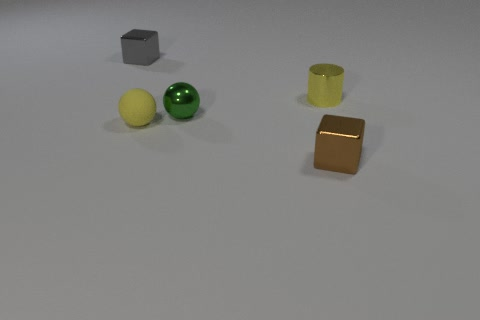

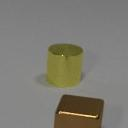

In [5]:
# test result at random
frame_id = np.random.randint(0, len(frame_names))
print(f"frame {frame_id}")
Image.open(os.path.join(base_path_video_frames, f"{frame_id:05d}.jpg")).show()
Image.open(os.path.join(target_folder, f"{frame_id:05d}.jpg")).show()

## Manually crop a single image

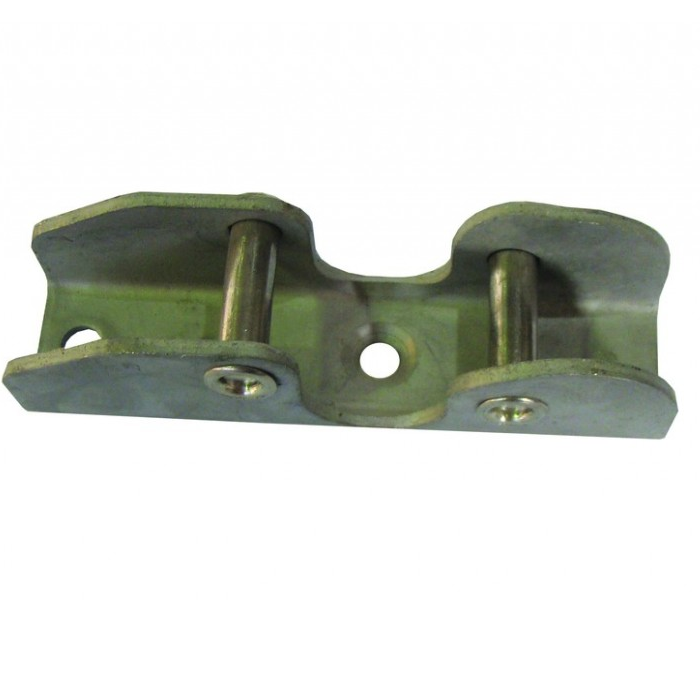

In [6]:
# manual image cropping on single images
img = np.array(Image.open("/app/ncb/test_images/Gegenhalter Krone oben 515000704.jpg"))
padding_size = 100
img = Image.fromarray(
    np.pad(
        img,
        pad_width= (
            (padding_size, padding_size),
            (0, 0),
            (0, 0),
        ),
        mode="constant",
        constant_values=255,
    )
)
# img.show()
offset = 700
x, y = 260, 100
img = img.crop((x, y, x + offset, y + offset))
img.show()
img.save("/app/ncb/square_imgs/test_images/Gegenhalter_Krone.jpg")

## Downsize images and put them all in a single folder

In [4]:
import os
import shutil

# Source directory (folder with subfolders containing images)
source_dir = "/app/ncb/car_parts_40/car_parts_50/train"

# Destination directory (where all images will be copied)
destination_dir = "/app/ncb/car_parts_40/car_parts_50/all_train_imgs"

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# Supported image file extensions
image_extensions = (".jpg")

# Walk through all subfolders and files
for root, _, files in os.walk(source_dir):
    for file in files:
        if file.lower().endswith(image_extensions):  # Check if file is an image
            source_path = os.path.join(root, file)  # Full path to the image
            destination_path = os.path.join(destination_dir, file)
            
            # Avoid overwriting files with the same name
            counter = 1
            while os.path.exists(destination_path):
                name, ext = os.path.splitext(file)
                new_filename = f"{name}_{counter}{ext}"
                destination_path = os.path.join(destination_dir, new_filename)
                counter += 1
            
            # Copy the image to the destination folder
            shutil.copy2(source_path, destination_path)
            # print(f"Copied: {source_path} -> {destination_path}")

print("All images have been copied.")



All images have been copied.


## Pad video frames to square shape

In [5]:
def pad_to_square(image, padding_mode="edge"):
    """
    Pad a given rectangular image to a square with specified padding mode.

    Args:
    - image (np.array): Input image (H, W, C).
    - padding_mode (str): Padding mode ('edge' for edge padding).

    Returns:
    - padded_image (np.array): Padded square image.
    """
    height, width, channels = image.shape
    max_size = max(height, width)

    # Calculate padding sizes
    pad_top = 0 if height == max_size else (max_size - height) // 2
    pad_bottom = max_size - height - pad_top
    pad_left = 0 if width == max_size else (max_size - width) // 2
    pad_right = max_size - width - pad_left

    # Use numpy.pad to pad the image
    padded_image = np.pad(image, 
                          ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                          mode=padding_mode)

    return padded_image


def pad_video_frames_in_folder_to_squares(folder_path, output_folder_path, padding_mode="edge"):
    """
    Process all images in the folder, pad them to a square, and save the result.

    Args:
    - folder_path (str): Path to the folder containing images.
    - output_folder_path (str): Path where padded images will be saved.
    """
    os.makedirs(output_folder_path)
    print(f"Writing to: {output_folder_path}")

    # Loop over all image files in the folder
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)

        # Only process image files
        if filename.lower().endswith(("png", "jpg", "jpeg")):
            # Open the image using PIL
            with Image.open(image_path) as img:
                # Convert the image to a NumPy array
                image_array = np.array(img)

                # Pad the image to square
                padded_image = pad_to_square(image_array, padding_mode=padding_mode)

                # Convert the padded image back to a PIL image
                padded_img = Image.fromarray(padded_image)

                # Save the padded image to the output folder
                output_image_path = os.path.join(output_folder_path, filename)
                padded_img.save(output_image_path)

In [6]:
video_name = "video_10000"

base_path_video_frames = "/app/ncb/edited_videos"
target_base_path = "/app/ncb/square_video_frames"
source_path = os.path.join(base_path_video_frames, video_name, "video_frames")
target_path = os.path.join(target_base_path, video_name)

pad_video_frames_in_folder_to_squares(source_path, target_path)

Writing to: /app/ncb/square_video_frames/video_10000


FileNotFoundError: [Errno 2] No such file or directory: '/app/ncb/edited_videos/video_10000/video_frames'

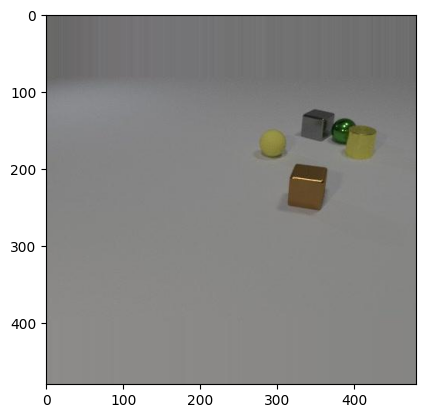

In [14]:
plt.imshow(Image.open("/app/ncb/square_video_frames/video_10001/00100.jpg"))

## Turn videos into frames for ncb training

In [3]:
def split_video_into_frames(video_id: int):
    # setup paths based on video id
    video_path = f"/app/clevrer_videos/video_{video_id}.mp4"
    base_path_video_frames = f"/app/clevrer_video_frames"

    # create frames from video
    os.makedirs(base_path_video_frames, exist_ok=True)
    command = f"cd {os.path.dirname(video_path)} && ffmpeg -i {os.path.basename(video_path)} -q:v 2 -start_number 0 {base_path_video_frames}/{video_id}_'%03d.jpg'"
    subprocess.run(command, shell=True)

video_id = range(10000, 11000)
random_ids = random.sample(video_id, 100)
[split_video_into_frames(id) for id in random_ids]

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,